<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Imports

In [81]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix, roc_auc_score

# Data loading and inspection

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

In [4]:
len(full_data['labeled_data']['data'])

2000

In [5]:
full_data.keys()

dict_keys(['unlabeled_data', 'labeled_data', 'representative_set_1', 'representative_set_2'])

In [6]:
unlabeled_data = np.array(full_data['unlabeled_data']) / 255.0
labeled_data_X = np.array(full_data['labeled_data']['data']) / 255.0
labeled_data_y = np.array(full_data['labeled_data']['labels'])
representative_set_1_X = np.array(full_data['representative_set_1']['data']) / 255.0
representative_set_1_y = np.array(full_data['representative_set_1']['labels'])
representative_set_2_X = np.array(full_data['representative_set_2']['data']) / 255.0
representative_set_2_y = np.array(full_data['representative_set_2']['labels'])

In [7]:
labeled_data_X.shape, labeled_data_y.shape

((2000, 1, 32, 32), (2000, 5))

In [8]:
labeled_data_X[0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [9]:
from torch.utils.data import Dataset, DataLoader,TensorDataset, random_split
import numpy as np
from PIL import Image

class UnlabelDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data)

        
    def __getitem__(self, index):
        x = self.data[index]
        
        return x
    
    def __len__(self):
        return len(self.data)

class LabelDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets)

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [10]:
unlabeled_dataset = UnlabelDataset(unlabeled_data)
labeled_dataset = LabelDataset(labeled_data_X, labeled_data_y)
representative_dataset_1 = LabelDataset(representative_set_1_X, representative_set_1_y)
representative_dataset_2 = LabelDataset(representative_set_2_X, representative_set_2_y)

In [11]:
len(unlabeled_dataset)

26000

In [12]:
batch_size = 100
kwargs = {'num_workers': 1, 'pin_memory': True}

unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=batch_size, **kwargs)
labeled_loader = torch.utils.data.DataLoader(labeled_dataset, batch_size=batch_size, **kwargs)
representative_loader_1 = torch.utils.data.DataLoader(representative_dataset_1, batch_size=4, **kwargs)
representative_loader_2 = torch.utils.data.DataLoader(representative_dataset_2, batch_size=4, **kwargs)

In [13]:
inputs, classes = next(iter(representative_loader_1))

In [14]:
inputs.shape, classes.shape

(torch.Size([4, 1, 32, 32]), torch.Size([4, 6]))

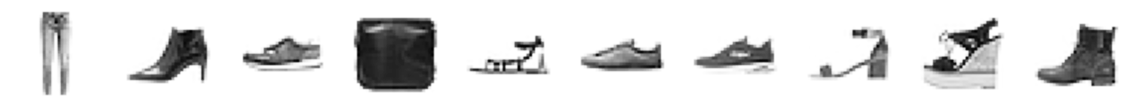

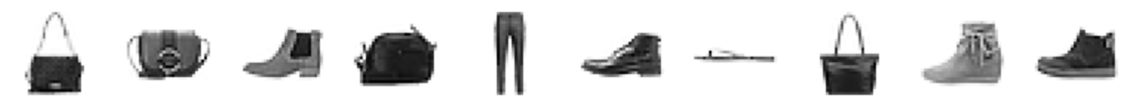

In [16]:
def show_images(x, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(batch_size, 32, 32)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys")
        ax[idx].axis('off')
    plt.show()

for loader in [unlabeled_loader, labeled_loader]:
    if loader == unlabeled_loader:
        for x in loader:
            show_images(x)
            break
    else:
        for x, y in loader:
            show_images(x)
            break

In [226]:
# hyper parameters
latent_dim = 10
x_dim = 32*32
hidden_dim = 500

lr = 1e-3
epochs = 50


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc_input = nn.Linear(input_dim, 512)
        self.fc_hidden = nn.Linear(512, 256)
        self.fc_hidden1 = nn.Linear(256, 128)
        self.fc_hidden2 = nn.Linear(128, 64)
        self.fc_hidden3 = nn.Linear(64, 32)
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_sigma = nn.Linear (32, latent_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_input(x))
        h = torch.relu(self.fc_hidden(h))
        h = torch.relu(self.fc_hidden1(h))
        h = torch.relu(self.fc_hidden2(h))
        h = torch.relu(self.fc_hidden3(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        
        return z


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_hidden = nn.Linear(latent_dim, 32)
        self.fc_hidden1 = nn.Linear(32, 64)
        self.fc_hidden2 = nn.Linear(64, 128)
        self.fc_hidden3 = nn.Linear(128, 256)
        self.fc_hidden4 = nn.Linear(256, 512)
        self.fc_output = nn.Linear(512, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden(x))
        h = torch.relu(self.fc_hidden1(h))
        h = torch.relu(self.fc_hidden2(h))
        h = torch.relu(self.fc_hidden3(h))
        h = torch.relu(self.fc_hidden4(h))
        x_reconstr = torch.sigmoid(self.fc_output(h))
        return x_reconstr

In [227]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
                
    def forward(self, x):
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        
        return x_reconstr, mu, log_sigma

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

vae = VAE(encoder=encoder, decoder=decoder).to(DEVICE)

In [228]:
def loss_function(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

In [229]:
x = next(iter(unlabeled_loader))
x.shape

torch.Size([100, 1, 32, 32])

In [230]:
optimizer = Adam(vae.parameters(), lr=lr)

print("Training VAE...")
vae.train()

avg_losses = []
recons_losses = []
kl_losses = []

for epoch in range(epochs):
    overall_loss = 0.0
    overall_reconstr_loss = 0.0
    overall_kl_loss = 0.0
    for batch_idx, x in enumerate(unlabeled_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_reconstr, mu, log_sigma = vae(x)
        loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
        
    n_datapoints = batch_idx * batch_size
    avg_losses.append(overall_loss / n_datapoints)
    recons_losses.append(overall_reconstr_loss / n_datapoints)
    kl_losses.append(overall_kl_loss / n_datapoints)
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints)
    
print("Training complete!")

Training VAE...
	Epoch 1 	Average Loss:  66.26452629177727 	Reconstruction Loss: 64.94668509818412 	KL Loss: 1.31784131657663
	Epoch 2 	Average Loss:  42.158045932372104 	Reconstruction Loss: 38.61054546105816 	KL Loss: 3.5475003776403007
	Epoch 3 	Average Loss:  32.71907038979549 	Reconstruction Loss: 27.98012495475386 	KL Loss: 4.738945459785609
	Epoch 4 	Average Loss:  29.67304187907215 	Reconstruction Loss: 25.099412205523045 	KL Loss: 4.573629624061143
	Epoch 5 	Average Loss:  28.44950945644305 	Reconstruction Loss: 23.981962730378257 	KL Loss: 4.467546764948193
	Epoch 6 	Average Loss:  27.850373280646718 	Reconstruction Loss: 23.357005063797057 	KL Loss: 4.493368268694196
	Epoch 7 	Average Loss:  27.402719792546453 	Reconstruction Loss: 22.902548172998614 	KL Loss: 4.50017166314438
	Epoch 8 	Average Loss:  27.142746742277993 	Reconstruction Loss: 22.617884167998913 	KL Loss: 4.52486259902306
	Epoch 9 	Average Loss:  26.93596986041566 	Reconstruction Loss: 22.38987140670246 	KL Lo

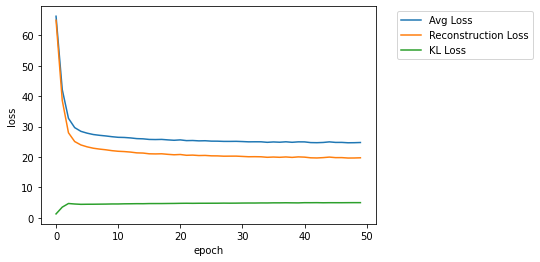

In [239]:
# plotting of losses
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(avg_losses, label='Avg Loss')
plt.plot(recons_losses, label="Reconstruction Loss")
plt.plot(kl_losses, label="KL Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [240]:
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
    constant_term = x_dim * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
    elbo = - reconstr_loss - constant_term - kl_loss
    return elbo, reconstr_loss, kl_loss

elbo


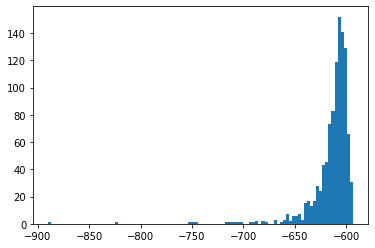

reconstruction loss


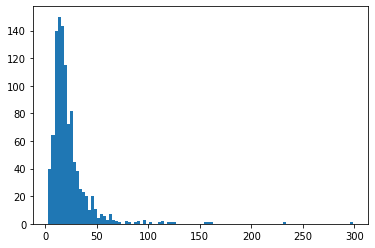

generated images


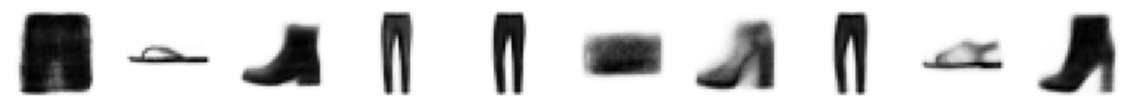

In [241]:
vae.eval()

representative_elbo_1 = []
representative_elbo_2 = []
representative_rec_1 = []
representative_rec_2 = []

with torch.no_grad():
    for x, _ in representative_loader_1:
        x = x.view(4, x_dim)
        x = x.to(DEVICE)
        x_rec, mu, log_sigma = vae(x)
        elbo, rec, kl = elbo_elementwise(x, x_rec, mu, log_sigma)
        representative_elbo_1.append(elbo.cpu().numpy())
        representative_rec_1.append(rec.cpu().numpy())
    
    for x, _ in representative_loader_2:
        x = x.view(4, x_dim)
        x = x.to(DEVICE)
        x_rec, mu, log_sigma = vae(x)
        elbo, rec, kl = elbo_elementwise(x, x_rec, mu, log_sigma)
        representative_elbo_2.append(elbo.cpu().numpy())
        representative_rec_2.append(rec.cpu().numpy())
    
    representative_elbo_1 = np.concatenate(representative_elbo_1, 0)
    representative_elbo_2 = np.concatenate(representative_elbo_2, 0)
    representative_rec_1 = np.concatenate(representative_rec_1, 0)
    representative_rec_2 = np.concatenate(representative_rec_2, 0)

    print('elbo')
    plt.hist(representative_elbo_1, bins=100)
    plt.show()

    print('reconstruction loss')
    plt.hist(representative_rec_1, bins=100)
    plt.show()

    noise = torch.randn((100, latent_dim), device=DEVICE)
    generated = decoder(noise).cpu()
    generated = generated.view(100, x_dim)
    print('generated images')
    show_images(generated)

In [242]:
representative_elbo_2

array([-605.9843, -614.6659, -603.653 , ..., -617.1786, -599.3799,
       -595.7916], dtype=float32)

In [243]:
representative_dataset_2[0][1]

tensor([1., 0., 0., 0., 0., 0.])

In [244]:
representative_labels_1 = []
for i in range(len(representative_dataset_1)):
    if representative_dataset_1[i][1][5] == 1:
        representative_labels_1.append(1)
    else:
        representative_labels_1.append(0)

In [245]:
scores_1 = - representative_elbo_1
scores_1 = (scores_1 - scores_1.min())/(scores_1.max()-scores_1.min())

In [246]:
scores_1_norm = np.where(scores_1 > 0.5, 1, 0)
print(confusion_matrix(representative_labels_1, scores_1_norm))

[[1000    0]
 [  47    5]]


In [247]:
tn, fp, fn, tp = confusion_matrix(representative_labels_1, scores_1_norm).ravel()
(tn, fp, fn, tp)

(1000, 0, 47, 5)

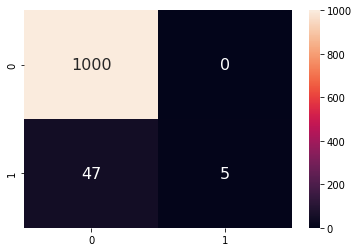

In [248]:
conf = [[tn,fp],[fn,tp]]
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')

roc_auc=0.9320384615384616


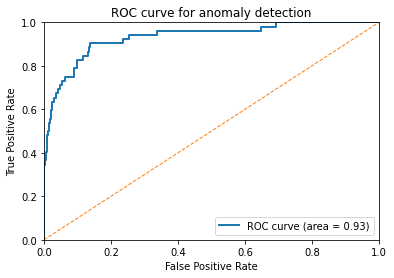

pr_auc=0.6304656103908367


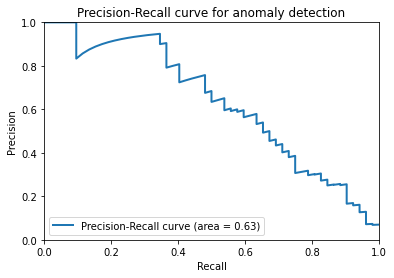

In [249]:
fpr, tpr, roc_thresholds = roc_curve(representative_labels_1, scores_1)
precision, recall, pr_thresholds = precision_recall_curve(representative_labels_1, scores_1)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

print(f'roc_auc={roc_auc}')
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for anomaly detection')
plt.legend(loc='lower right')
plt.show()


print(f'pr_auc={pr_auc}')
plt.figure()
plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for anomaly detection')
plt.legend(loc='lower left')
plt.show()

In [250]:
roc_auc_score(representative_labels_1, scores_1)

0.9320384615384616

In [251]:
representative_labels_2 = []
for i in range(len(representative_dataset_2)):
    if representative_dataset_2[i][1][5] == 1:
        representative_labels_2.append(1)
    else:
        representative_labels_2.append(0)

In [252]:
scores_2 = - representative_elbo_2
scores_2 = (scores_2 - scores_2.min())/(scores_2.max()-scores_2.min())

In [253]:
scores_2_norm = np.where(scores_2 > 0.5, 1, 0)
print(confusion_matrix(representative_labels_2, scores_2_norm))

[[999   1]
 [ 45   7]]


roc_auc=0.9251538461538462


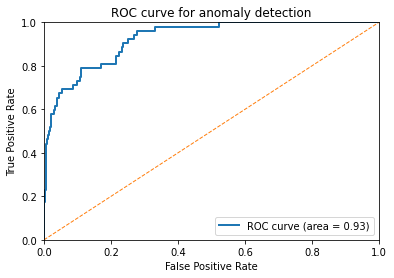

pr_auc=0.561468970140096


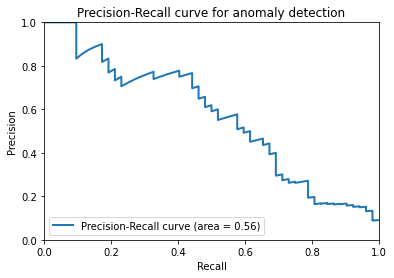

In [254]:
fpr, tpr, roc_thresholds = roc_curve(representative_labels_2, scores_2)
precision, recall, pr_thresholds = precision_recall_curve(representative_labels_2, scores_2)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

print(f'roc_auc={roc_auc}')
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for anomaly detection')
plt.legend(loc='lower right')
plt.show()


print(f'pr_auc={pr_auc}')
plt.figure()
plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for anomaly detection')
plt.legend(loc='lower left')
plt.show()

# Data augmentation and pipeline

In [ ]:
# code for data augmentation pipeline 

# Model definitions

In [ ]:
# code for model definitions goes here

# Training and validation loop

In [ ]:
# write your training and validation loop here

In [ ]:
# perform training

# Inspection, Validation, and Analysis

In [ ]:
# Inspect, validate, and analyse your trained model